<a href="https://colab.research.google.com/github/lenonborges/PucMvp/blob/main/MVP_Project2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Definição do Problema

Objetivo: entender e descrever claramente o problema que está sendo resolvido.

Qual é a descrição do problema?
- Criação de um modelo para classificação do tópico de uma notícia.

Você tem premissas ou hipóteses sobre o problema? Quais?
- Possibilidade de estimação da categoria de uma notícia através apenas de seu headline ou resumo.




Descreva o seu dataset (atributos, imagens, anotações, etc).
- O dataset possui cerca de 210k news headlines de 2012 a 2022 do site HuffPost

In [1]:
pip install pandas_profiling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

<ipython-input-2-f1b4f022bd55>:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Obtenção e Exploração dos dados

In [3]:
url = 'https://raw.githubusercontent.com/lenonborges/PucMvp/main/News_Category_Dataset_v3.json'
df = pd.read_json(url, lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
# Descricoes gerais do dataset
df.describe() # .style.set_properties(**{'background-color': '#F0F0F0',                                    'color': '#222222',                                    'border': '1.5px  solid black'})

,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [6]:
# Pandas Profiling p estatisticas descritivas do dataset
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# 1.2 Text data visualization

In [8]:
# dropando colunas irrelegantes para o problema
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [9]:
#1.2.1 TOP 10 Categories of News Articles

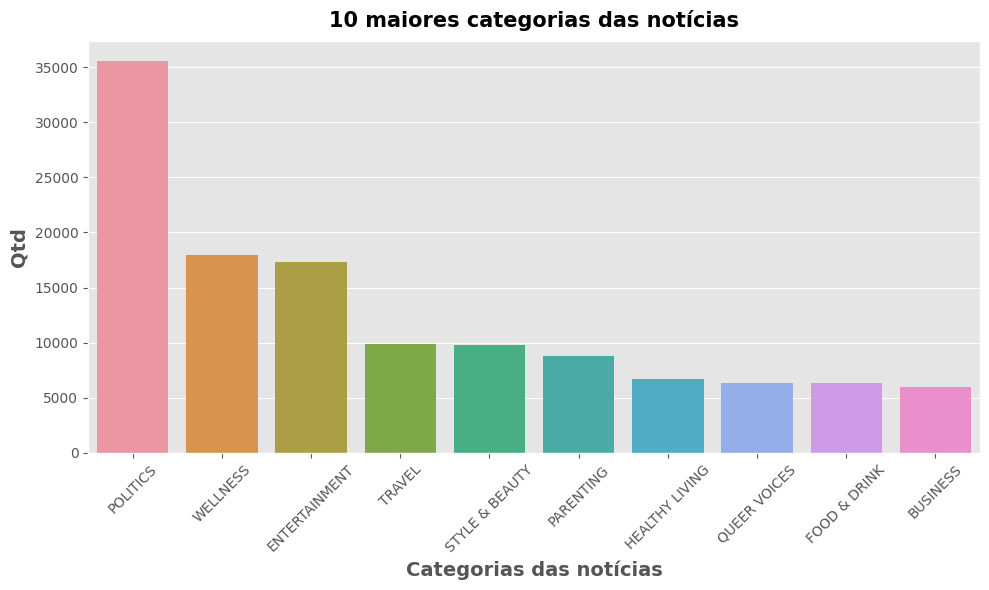

In [10]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(y=np.array(cat_df.numcat)[:10], x=np.array(cat_df.news_classes)[:10])
#ax = sns.barplot( data=valores, ) #np.array(cat_df.news_classes)[:10],
#for p in ax.patches:
 #   ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("10 maiores categorias das notícias", size=15)
plt.xlabel("Categorias das notícias", size=14)
plt.xticks(rotation=45)
plt.ylabel("Qtd", size=14)
plt.show()

In [12]:
# Criando um dataframe final com a combinação do título da noticia e uma breve descrição da mesma
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [13]:
# Obtendo o tamanho maximo das noticias para cada categoria
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
41,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
38,WELLNESS,1036


In [14]:
# Obtendo o tamanho minimo das noticias para cada categoria
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
35,U.S. NEWS,73
8,DIVORCE,66
33,THE WORLDPOST,56
36,WEDDINGS,54
21,MONEY,51


#Preparação dos dados

In [15]:
# Criando um novo DF da categoria e do comprimento de cada noticia dessa categoria
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# lista das 10 maiores categorias do df
categories = cat_df['news_classes'][:10].to_list()

# removendo dados da categoria politica
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index)
list_16 = politics_list[:16000]

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)

In [16]:
# limpando os dados de texto usando regex
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removendo stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # aplicando word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [17]:
# aplicando a função data cleaning p coluna de comprimento das noticias
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

# Tokenization and vectorization


One-hot encoding e indexação de dados de treino e teste

In [18]:
# one hot encoding usando keras e pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train)
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train)
train_padseq = pad_sequences(train_seq, maxlen=20)

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000
total_words = len(word_index)
maxlen = 20
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (193527,)
shape of target variable:  (193527,)
Length of word index: 181108


# Model training using embedding layer and RNN (Baseline)

 Baseline model 1 with SimpleRNN and embedding layer




In [19]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            12677560  
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 42)                1

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',patience=5,verbose=1,mode='min')
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, batch_size=256, epochs=15, validation_split=0.2)

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
484/484 [==============================] - 181s 361ms/step - loss: 3.2947 - accuracy: 0.1541 - val_loss: 2.8327 - val_accuracy: 0.2796
Epoch 2/15
484/484 [==============================] - 164s 338ms/step - loss: 2.7667 - accuracy: 0.2855 - val_loss: 2.5567 - val_accuracy: 0.3231
Epoch 3/15
484/484 [==============================] - 150s 309ms/step - loss: 2.4842 - accuracy: 0.3514 - val_loss: 2.3466 - val_accuracy: 0.3900
Epoch 4/15
484/484 [==============================] - 150s 309ms/step - loss: 2.2639 - accuracy: 0.4100 - val_loss: 2.2530 - val_accuracy: 0.4211
Epoch 5/15
484/484 [==============================] - 156s 323ms/step - loss: 2.1085 - accuracy: 0.4518 - val_loss: 2.2241 - val_accuracy: 0.4283
Epoch 6/15
484/484 [==============================] - 155s 320ms/step - loss: 1.9846 - accuracy: 0.4844 - val_loss: 2.1788 - val_accuracy: 0.4418
Epoch 7/15
484/484 [==============================] - 155s 321ms/step - loss: 1.8903 - accuracy: 0.5069 - val_loss: 2.1521 -

Modelo 2 treinando com Conv1D, Bi-directional RNN, LSTMs e GRU layer

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

In [ ]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',patience=5,verbose=1,mode='min')
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit
history2 = model2.fit(train_padseq, y_train,batch_size=128, epochs=15, validation_split=0.2,shuffle=True)

# avaliando o modelo
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)